In [104]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

## OBTENER DATOS

In [105]:
df_diabetes = pd.read_csv('diabetes.csv')

In [106]:
df_diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


**PREPROCESAMIENTO DE LOS DATOS**

* Construcción de una función que realice el particionado completo.

In [107]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [108]:
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [109]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* Comprobación de si existen valores nulos

In [110]:
is_null = df_diabetes.isna().any()
is_null[is_null]

Series([], dtype: bool)

* Se reemplazarán los valores cero de aquellas columnas que podrían tener error de registro, por la mediana de ese campo.

In [111]:
# Agrupa por la etiqueta y calcula la mediana para cada columna
medians = df_diabetes.groupby('Outcome')[["Glucose", "BMI", "BloodPressure", "SkinThickness"]].median()

# Itera a través de las columnas de interés
for col in ["Glucose", "BMI", "BloodPressure", "SkinThickness"]:
    # Reemplaza los valores iguales a 0 por las medianas correspondientes
    df_diabetes.loc[(df_diabetes[col] == 0) & (df_diabetes['Outcome'] == 0), col] = medians.loc[0, col]
    df_diabetes.loc[(df_diabetes[col] == 0) & (df_diabetes['Outcome'] == 1), col] = medians.loc[1, col]

In [112]:
# Filtra las filas donde 'Insulin' no sea igual a cero y agrupa por 'Outcome'
filtered_data = df_diabetes[df_diabetes['Insulin'] != 0]

medians2 = filtered_data.groupby('Outcome')['Insulin'].median()

In [113]:
# Define una función que reemplace los ceros en 'Insulin' por la mediana correspondiente
def replace_insulin(row):
    if row['Insulin'] == 0:
        return medians2[row['Outcome']]
    else:
        return row['Insulin']

# Aplica la función a cada fila del DataFrame
df_diabetes['Insulin'] = df_diabetes.apply(replace_insulin, axis=1)

In [114]:
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.378906,27.43099,141.753906,32.433919,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.104431,9.32146,89.100847,6.880664,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.00000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,21.00000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,27.00000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.00000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.00000,846.000000,67.100000,2.420000,81.000000,1.000000


In [115]:
conteo_de_ceros = (df_diabetes.iloc[:, :-1] == 0).sum()

print(conteo_de_ceros)

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


* División del conjunto de datos

In [116]:
# División del conjunto de datos
train_set, val_set, test_set = train_val_test_split(df_diabetes)

In [117]:
X_train = train_set.drop("Outcome", axis=1)
y_train = train_set["Outcome"].copy()

X_val = val_set.drop("Outcome", axis=1)
y_val = val_set["Outcome"].copy()

X_test = test_set.drop("Outcome", axis=1)
y_test = test_set["Outcome"].copy()

## SUPPORT VECTOR MACHINE: Kernel lineal

* Support vector machine (SVM) es un algoritmo de aprendizaje supervisado que se utiliza en muchos problemas de clasificación y  regresión, incluidas aplicaciones médicas de procesamiento de señales, procesamiento del lenguaje natural y reconocimiento de imágenes y voz
* El objetivo del algoritmo SVM es encontrar un hiperplano que separe de la mejor forma posible dos clases diferentes de puntos de datos. 

Kernel Lineal

In [118]:
# Entrenamiento con todo el conjunto de datos
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [119]:
y_pred = svm_clf.predict(X_val)

In [120]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_pred, y_val),2))
print("Precisión:", round(precision_score(y_pred, y_val),2))
print("Recall:", round(recall_score(y_pred, y_val),2))
print("F1 score:", round(f1_score(y_pred, y_val),2))

Accuracy del modelo:  0.77
Precisión: 0.66
Recall: 0.65
F1 score: 0.65


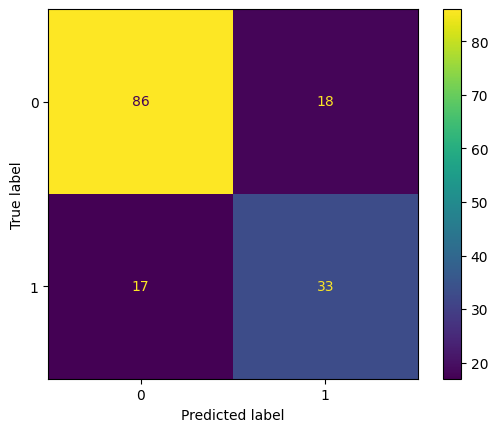

In [121]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [122]:
svm_clf_sc = Pipeline([
        ("scaler", RobustScaler()),
        ("linear_svc", SVC(kernel="linear", C=50)),
    ])

svm_clf_sc.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [123]:
y_pred = svm_clf_sc.predict(X_val)

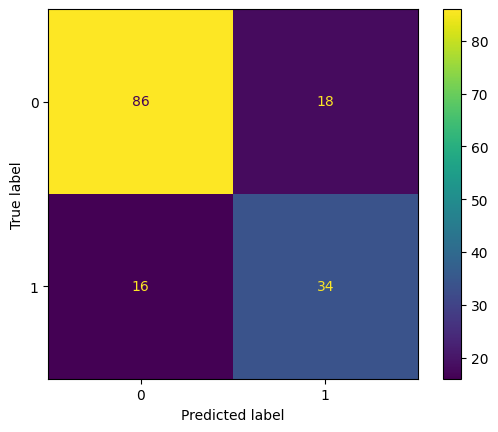

In [124]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [125]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_pred, y_val),2))
print("Precisión:", round(precision_score(y_pred, y_val),2))
print("Recall:", round(recall_score(y_pred, y_val),2))
print("F1 score:", round(f1_score(y_pred, y_val),2))

Accuracy del modelo:  0.78
Precisión: 0.68
Recall: 0.65
F1 score: 0.67


* SMV: Kernel no lineal

* Polynomial Kernel

In [126]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=40)
svm_clf.fit(X_train, y_train)

SVC(C=40, coef0=10, kernel='poly')

In [127]:
y_pred = svm_clf.predict(X_val)

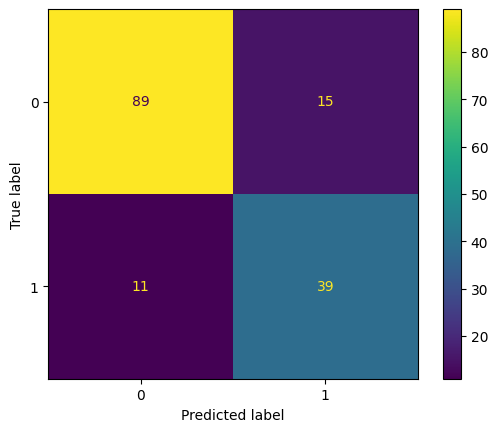

In [128]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [129]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_pred, y_val),2))
print("Precisión:", round(precision_score(y_pred, y_val),2))
print("Recall:", round(recall_score(y_pred, y_val),2))
print("F1 score:", round(f1_score(y_pred, y_val),2))

Accuracy del modelo:  0.83
Precisión: 0.78
Recall: 0.72
F1 score: 0.75


* Gaussian Kernel

In [130]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.1, C=100))
        ])

rbf_kernel_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('svm_clf', SVC(C=100, gamma=0.1))])

In [131]:
y_pred = rbf_kernel_svm_clf.predict(X_val)

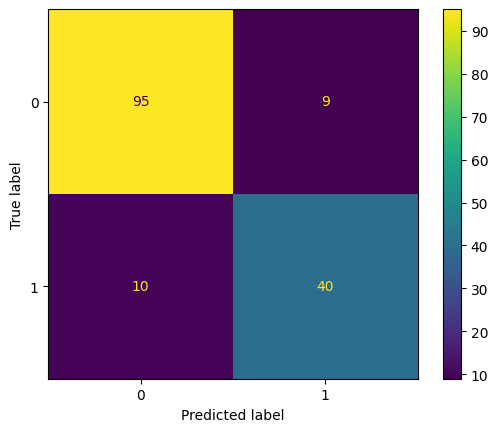

In [132]:
cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [133]:
# Evaluar el rendimiento del modelo

print("Accuracy del modelo: ",round(accuracy_score(y_pred, y_val),2))
print("Precisión:", round(precision_score(y_pred, y_val),2))
print("Recall:", round(recall_score(y_pred, y_val),2))
print("F1 score:", round(f1_score(y_pred, y_val),2))

Accuracy del modelo:  0.88
Precisión: 0.8
Recall: 0.82
F1 score: 0.81


In [134]:
classification_rep = classification_report(y_pred, y_val)
print(f"\nReporte de clasificación:\n{classification_rep}")



Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       105
           1       0.80      0.82      0.81        49

    accuracy                           0.88       154
   macro avg       0.86      0.86      0.86       154
weighted avg       0.88      0.88      0.88       154



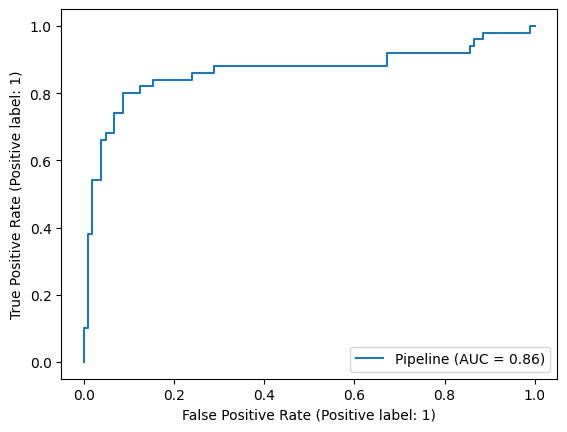

In [135]:
roc_display = RocCurveDisplay.from_estimator(rbf_kernel_svm_clf, X_val, y_val)

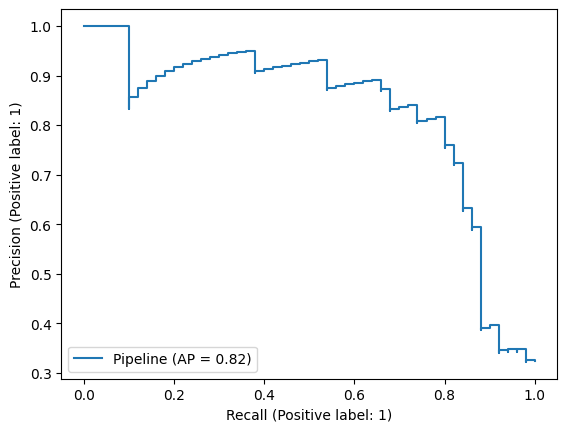

In [136]:
prec_recall_display = PrecisionRecallDisplay.from_estimator(rbf_kernel_svm_clf, X_val, y_val)